In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

pd.set_option('display.max_columns', 90)
pd.options.mode.chained_assignment = None
pd.options.mode.copy_on_write = True

In [3]:
movies = pd.read_csv('imdb-cleaned.csv')

# Data Preparation

In [4]:
movies['total_votes'] = movies.loc[:, 'rating_1':'rating_10'].sum(axis='columns')

We made a variable `total_votes` with the total number of user votes on each movie.

In [9]:
def calc_unweighted_rating(row):
    return sum([i * row[f'rating_{i}'] for i in range(1, 11)]) / row['total_votes']

movies['unweighted_rating'] = movies.apply(calc_unweighted_rating, axis='columns')

In [10]:
def calc_polarization(row):
    total_score = 0
    for rating_1 in range(1, 11):
        for rating_2 in range(rating_1 + 1, 11):
            total_score += row[f'rating_{rating_1}'] / row['total_votes'] * row[f'rating_{rating_2}'] / row['total_votes'] * (rating_2 - rating_1)

    return total_score / 2.25

In [11]:
movies['polarization_score'] = movies.apply(calc_polarization, axis='columns')

We made a variable `polarization_score` with the polarization score for each movie's ratings calculated using a version of Esteban and Ray's algorithm [Esteban and Ray, 1993]. The algorithm is based on the premise that polarization in a distribution is equivalent to the sum of what they call the "effective antagonisms" in that distribution. Each pair of values—the 1s and the 10s, the 1s and the 9s, and so on—have an effective antagonism, which is a function of the difference between the two values and the number of instances of each. To find the effective antagonism between two values, we multiply the proportions of scores matching those two values in the overall distribution by each other, and then multiply that by the difference between the two values. This yields a score from 0 (not polarized at all—all ratings for the film are the same) to 2.25 (extremely polarized—exactly 50% 1s and 50% 10s). We then divide by 2.25 to obtain a score between 0 and 1, in order to produce a more intuitive number for polarization.

In [12]:
def calc_country_rating(country_idx, row):
    total_rating = 0
    total_votes = 0
    for rating in range(1, 11):
        total_rating += rating * row[f'country_{country_idx}_rating_{rating}']
        total_votes += row[f'country_{country_idx}_rating_{rating}']
    return total_rating / total_votes

In [13]:
for i in range(5):
    movies[f'country_{i}_rating'] = movies.apply(lambda row: calc_country_rating(i, row), axis='columns')

We made variables `country_{0...4}_rating` with the average rating for each of the top five countries with the most votes for each movie.

In [14]:
def calc_ptp(row):
    ptp = np.ptp(row.loc['country_0_rating':'country_4_rating'])

    max_country_idx = np.argmax(row.loc['country_0_rating':'country_4_rating'])
    min_country_idx = np.argmin(row.loc['country_0_rating':'country_4_rating'])
    max_country = row[f'country_{max_country_idx}']
    min_country = row[f'country_{min_country_idx}']

    return pd.Series([ptp, max_country, min_country])

In [15]:
movies[['country_ptp', 'max_country_ptp', 'min_country_ptp']] = movies.apply(calc_ptp, axis='columns')

We made a variable `country_ptp` with the difference between the highest and lowest average ratings between the top five countries with the most votes for each movie. The variables `max_country_ptp` and `min_country_ptp` record the country codes of the two countries with the highest and lowest average ratings for each movie, respectively.

In [16]:
movies['rating_diff'] = movies['weighted_rating'] - movies['unweighted_rating']

We made a variable `rating_diff` with the difference between the weighted (by IMDb) rating and the unweighted rating for each movie.

In [17]:
movies_us_release = movies.loc[movies['gross'].notna()]
movies_us_release['gross'] = movies_us_release['gross'].str[1:].str.replace(',', '')
movies_us_release = movies_us_release[movies_us_release['gross'] != '']
movies_us_release['gross'] = movies_us_release['gross'].astype('int')

Here, we cleaned the `gross` column to remove commas and the dollar sign and casted it as an int. We also excluded any movies that did not have a value in the `gross` column (movies that did not have an American theatrical release).

# EDA

In [18]:
movies_us_release.sort_values('polarization_score', ascending=False).head(10)

,id,title,genres,weighted_rating,release_year,gross,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,country_0,country_0_rating_1,country_0_rating_2,country_0_rating_3,country_0_rating_4,country_0_rating_5,country_0_rating_6,country_0_rating_7,country_0_rating_8,country_0_rating_9,country_0_rating_10,country_1,country_1_rating_1,country_1_rating_2,country_1_rating_3,country_1_rating_4,country_1_rating_5,country_1_rating_6,country_1_rating_7,country_1_rating_8,country_1_rating_9,country_1_rating_10,country_2,country_2_rating_1,country_2_rating_2,country_2_rating_3,country_2_rating_4,country_2_rating_5,country_2_rating_6,country_2_rating_7,country_2_rating_8,country_2_rating_9,country_2_rating_10,country_3,country_3_rating_1,country_3_rating_2,country_3_rating_3,country_3_rating_4,country_3_rating_5,country_3_rating_6,country_3_rating_7,country_3_rating_8,country_3_rating_9,country_3_rating_10,country_4,country_4_rating_1,country_4_rating_2,country_4_rating_3,country_4_rating_4,country_4_rating_5,country_4_rating_6,country_4_rating_7,country_4_rating_8,country_4_rating_9,country_4_rating_10,total_votes,unweighted_rating,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff
3314,tt4776998,The Promise,"Action,Adventure,Drama",6.1,2017,8224288,71664,785,464,775,1792,4218,5848,4468,3091,86259,US,1836,94,81,184,401,988,1337,1139,918,21028,TR,18267,363,124,91,90,103,93,42,26,503,RU,266,7,10,17,42,77,90,52,39,8778,GB,710,21,19,61,130,361,458,332,167,3346,AM,5,2,0,3,3,19,33,24,53,4487,179364,6.016163,0.979430,8.853424,1.372856,9.621135,7.973952,9.920069,8.547214,AM,TR,0.083837
4283,tt6277462,Brahmastra Part One: Shiva,"Action,Adventure,Fantasy",5.6,2022,7839108,42059,3965,2358,2499,3614,4782,6661,6505,6935,34225,IN,34387,2965,1612,1575,2141,2837,4297,4688,5643,28711,US,3172,418,301,348,557,730,939,748,523,1805,GB,1606,193,132,172,262,384,470,389,233,946,BD,446,83,66,107,180,237,249,177,124,664,CA,503,66,39,40,58,69,77,71,70,359,113603,5.432541,0.955619,5.454443,5.112881,5.149154,6.204458,5.135355,1.091577,BD,US,0.167459
3628,tt26932223,Bhool Bhulaiyaa 3,"Comedy,Fantasy,Horror",4.7,2024,2230000,22601,5180,4905,3708,1539,1559,1177,3408,9233,23616,IN,21315,4807,4518,3221,872,910,732,3135,9039,22935,US,377,117,125,163,217,223,144,95,70,159,GB,165,61,63,73,112,131,74,38,22,100,BD,156,44,53,72,106,84,67,45,26,92,PK,87,28,27,32,42,38,30,20,8,77,76926,5.645906,0.950316,5.708858,4.762722,4.927294,4.977181,5.146530,0.946136,IN,US,-0.945906
4172,tt10028196,Laal Singh Chaddha,"Comedy,Drama,Romance",5.6,2022,3401324,97775,4265,1436,973,1495,2450,3538,7441,14403,45489,IN,84276,3317,979,498,642,942,1477,5359,12759,35359,US,5676,406,161,151,226,388,572,611,470,2525,GB,3083,192,83,74,145,220,318,359,272,1334,CA,845,49,14,21,25,56,88,98,99,1067,BD,567,45,41,53,92,130,172,180,142,900,179265,4.493298,0.936659,4.301501,4.416682,4.431414,6.135055,6.526270,2.224769,BD,IN,1.106702
4106,tt10083340,Gangubai Kathiawadi,"Biography,Crime,Drama",7.8,2022,592000,16466,1161,763,856,1517,3068,6560,7448,4307,21612,IN,12214,777,465,487,777,1381,2733,3305,2137,16879,US,1852,166,114,128,252,521,1101,1236,669,2128,GB,1143,86,61,58,127,288,689,780,400,682,BD,154,16,22,36,60,151,334,302,157,307,PK,50,7,12,15,37,79,160,186,103,178,63758,6.444383,0.878236,6.387462,6.406269,5.928605,7.042885,7.417170,1.488566,PK,GB,1.355617
4055,tt12844910,Pathaan,"Action,Adventure,Thriller",5.8,2023,17487476,36924,3847,3083,3522,5861,7505,9778,10693,12329,66591,IN,28987,2539,1841,1922,2970,3568,6001,7972,9718,42838,US,2960,429,396,479,874,1158,1058,755,554,12747,BD,482,122,117,200,430,551,630,481,436,2830,GB,1451,235,211,252,461,657,634,409,361,1437,PK,318,79,73,83,133,164,151,96,385,1235,160133,6.701623,0.876027,6.507798,7.666604,7.615066,5.752783,7.477365,1.913821,US,GB,-0.901623
1989,tt0312528,The Cat in the Hat,"Adventure,Comedy,Family",4.1,2003

Here are the top ten movies sorted by one of our key explanatory variables, `polarization_score`.

In [19]:
movies_us_release.sort_values('rating_diff', ascending=False).head(10)

,id,title,genres,weighted_rating,release_year,gross,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,country_0,country_0_rating_1,country_0_rating_2,country_0_rating_3,country_0_rating_4,country_0_rating_5,country_0_rating_6,country_0_rating_7,country_0_rating_8,country_0_rating_9,country_0_rating_10,country_1,country_1_rating_1,country_1_rating_2,country_1_rating_3,country_1_rating_4,country_1_rating_5,country_1_rating_6,country_1_rating_7,country_1_rating_8,country_1_rating_9,country_1_rating_10,country_2,country_2_rating_1,country_2_rating_2,country_2_rating_3,country_2_rating_4,country_2_rating_5,country_2_rating_6,country_2_rating_7,country_2_rating_8,country_2_rating_9,country_2_rating_10,country_3,country_3_rating_1,country_3_rating_2,country_3_rating_3,country_3_rating_4,country_3_rating_5,country_3_rating_6,country_3_rating_7,country_3_rating_8,country_3_rating_9,country_3_rating_10,country_4,country_4_rating_1,country_4_rating_2,country_4_rating_3,country_4_rating_4,country_4_rating_5,country_4_rating_6,country_4_rating_7,country_4_rating_8,country_4_rating_9,country_4_rating_10,total_votes,unweighted_rating,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff
567,tt5971474,The Little Mermaid,"Adventure,Family,Fantasy",7.2,2023,298172056,42723,8622,6100,6535,11339,19356,24225,15986,7954,21104,US,13325,2714,1912,1813,2888,4920,7210,5907,3520,10357,GB,2522,635,474,603,1093,2011,2618,1685,753,1287,CA,1350,283,215,234,387,639,883,658,343,705,BR,1062,222,170,200,407,717,791,645,273,802,DE,1380,310,245,279,482,741,846,381,177,247,163944,5.229389,0.810203,5.656948,5.599737,5.414780,5.733976,4.665881,1.068096,BR,DE,1.970611
2127,tt1289401,Ghostbusters,"Action,Comedy,Fantasy",6.8,2016,128350574,43927,13107,14645,20793,33093,41211,34033,19284,8362,23725,US,12649,3665,3821,5156,8160,10892,10781,7097,3253,7732,GB,4749,1593,1915,2581,4043,5440,4805,2595,919,1854,CA,1576,598,606,780,1285,1642,1488,914,388,826,DE,1586,589,780,1052,1575,1719,1247,517,175,319,SE,1412,445,478,739,1229,1303,885,449,173,1154,252180,5.214490,0.705329,5.423845,5.183479,5.292190,4.721310,5.266602,0.702535,US,DE,1.585510
4106,tt10083340,Gangubai Kathiawadi,"Biography,Crime,Drama",7.8,2022,592000,16466,1161,763,856,1517,3068,6560,7448,4307,21612,IN,12214,777,465,487,777,1381,2733,3305,2137,16879,US,1852,166,114,128,252,521,1101,1236,669,2128,GB,1143,86,61,58,127,288,689,780,400,682,BD,154,16,22,36,60,151,334,302,157,307,PK,50,7,12,15,37,79,160,186,103,178,63758,6.444383,0.878236,6.387462,6.406269,5.928605,7.042885,7.417170,1.488566,PK,GB,1.355617
4172,tt10028196,Laal Singh Chaddha,"Comedy,Drama,Romance",5.6,2022,3401324,97775,4265,1436,973,1495,2450,3538,7441,14403,45489,IN,84276,3317,979,498,642,942,1477,5359,12759,35359,US,5676,406,161,151,226,388,572,611,470,2525,GB,3083,192,83,74,145,220,318,359,272,1334,CA,845,49,14,21,25,56,88,98,99,1067,BD,567,45,41,53,92,130,172,180,142,900,179265,4.493298,0.936659,4.301501,4.416682,4.431414,6.135055,6.526270,2.224769,BD,IN,1.106702
2826,tt10298810,Lightyear,"Animation,Action,Adventure",6.1,2022,118307188,23434,3069,3433,5621,12816,26610,26965,13452,4791,9256,US,8334,1256,1283,1942,3736,7139,7725,4665,2036,4067,GB,1325,257,337,640,1709,3455,3446,1603,484,698,CA,531,120,108,168,380,924,1028,492,181,383,BR,555,112,112,201,454,891,856,418,117,214,DE,248,54,83,142,410,947,925,411,108,125,129447,5.547792,0.665020,5.555935,5.945750,5.979606,5.614249,6.049812,0.493877,DE,US,0.552208
1119,tt2527336,Star Wars: Episode VIII - The Last Jedi,"Action,Adventure,Fantasy",6.9,2017,620181382,51466,19465,23687,31626,53578,94304,148659,130882,71081,65341,US,15524,5844,6996,9190,14670,24292,37480,35598,21935,21330,GB,5187,2180,2777,3728,6213,11005,17360,15365,7965,6193,DE,2480,1201,1494,2032,3386,5346,7881,6043,2862,1767,CA,1777,886,864,1153,1789,3202,4773,4196,2272,1886,SE,1814,710,915,120

Here are the top ten movies sorted by one of our key explanatory variables, `rating_diff`.

In [20]:
movies_us_release.sort_values('gross', ascending=False).head(10)

,id,title,genres,weighted_rating,release_year,gross,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,country_0,country_0_rating_1,country_0_rating_2,country_0_rating_3,country_0_rating_4,country_0_rating_5,country_0_rating_6,country_0_rating_7,country_0_rating_8,country_0_rating_9,country_0_rating_10,country_1,country_1_rating_1,country_1_rating_2,country_1_rating_3,country_1_rating_4,country_1_rating_5,country_1_rating_6,country_1_rating_7,country_1_rating_8,country_1_rating_9,country_1_rating_10,country_2,country_2_rating_1,country_2_rating_2,country_2_rating_3,country_2_rating_4,country_2_rating_5,country_2_rating_6,country_2_rating_7,country_2_rating_8,country_2_rating_9,country_2_rating_10,country_3,country_3_rating_1,country_3_rating_2,country_3_rating_3,country_3_rating_4,country_3_rating_5,country_3_rating_6,country_3_rating_7,country_3_rating_8,country_3_rating_9,country_3_rating_10,country_4,country_4_rating_1,country_4_rating_2,country_4_rating_3,country_4_rating_4,country_4_rating_5,country_4_rating_6,country_4_rating_7,country_4_rating_8,country_4_rating_9,country_4_rating_10,total_votes,unweighted_rating,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff
767,tt2488496,Star Wars: Episode VII - The Force Awakens,"Action,Adventure,Sci-Fi",7.8,2015,936662225,27880,9629,12221,18447,38353,84926,190116,260214,185343,166695,US,6100,2101,2779,4224,8900,19401,44012,63449,48400,46205,GB,1883,716,958,1655,3491,8467,20206,29135,20564,15669,DE,1063,441,636,1030,2100,4625,10392,12905,7834,4544,TR,1477,321,462,717,1506,3420,7109,8169,4364,4311,CA,931,685,509,551,1160,2610,5839,8315,5887,4587,993824,7.653741,0.458279,7.776843,7.760589,7.420518,7.280387,7.521980,0.496456,US,TR,0.146259
95,tt4154796,Avengers: Endgame,"Action,Adventure,Sci-Fi",8.4,2019,858373000,37552,6721,8475,12789,28268,63730,151796,278131,300378,447590,US,14084,1580,1855,2945,6356,14076,33937,67147,79717,119852,GB,1933,554,738,1159,2562,5969,14964,28647,32432,46987,IN,1559,235,251,362,793,1699,4838,11011,15679,40794,TR,3083,417,546,716,1820,4042,9319,14268,11813,18026,DE,807,287,402,622,1238,2877,6580,11193,11039,10631,1335430,8.325571,0.426909,8.319547,8.490176,8.927546,7.927010,8.095980,1.000535,IN,TR,0.074429
148,tt10872600,Spider-Man: No Way Home,"Action,Adventure,Fantasy",8.2,2021,804793477,17737,4207,5757,9018,20218,51250,128934,211345,196099,290943,US,3842,850,1105,1690,3828,9926,26599,50558,54529,78848,GB,1110,301,445,746,1675,4572,12557,22882,22852,29478,IN,1326,223,238,364,787,1711,4624,9041,10061,31534,TR,1199,195,313,469,1144,2818,7089,9397,6762,11172,DE,453,148,235,373,844,2110,5524,8475,7069,6266,935508,8.290365,0.409091,8.474646,8.417075,8.825519,7.998644,8.019018,0.826875,IN,TR,-0.090365
385,tt0499549,Avatar,"Action,Adventure,Fantasy",7.9,2009,749766139,29948,11717,16468,26200,53492,115048,246812,359928,264451,297318,US,9117,3507,4602,7042,13721,26922,52835,73901,54454,67566,GB,2287,1118,1604,2746,5470,11372,23295,30860,20694,19801,TR,991,248,355,554,1411,3810,10298,16742,11258,11340,DE,804,423,699,1095,2264,5093,11054,15260,10693,9563,IN,561,155,181,299,685,1920,5898,12579,12481,17026,1421382,7.827369,0.449041,7.699379,7.632075,7.988966,7.749701,8.536487,0.904413,IN,GB,0.072631
54,tt1745960,Top Gun: Maverick,"Action,Drama",8.2,2022,718732821,6177,2357,3276,5205,12544,35233,103877,201771,195131,193553,US,1841,657,913,1373,3194,8288,24119,51022,56103,64354,GB,452,224,309,511,1144,3338,10355,21319,21658,19654,IN,165,35,37,78,188,565,2284,6369,7690,10587,DE,267,116,140,252,572,1641,4700,7993,6583,4702,BR,94,41,55,99,258,811,2479,5720,6252,7546,759124,8.363157,0.348684,8.508100,8.410390,8.822344,8.074761,8.637722,0.747584,IN,DE,-0.163157
268,tt1825683,Black Panther,"Action,Adventure,Sci-Fi",7.3,2018,700059566,23980,8106,10709,18704,42395,102018,216606,217821,106657,118255,US,6377,1893,2428,4263,9645,22

Here are the top ten movies sorted by our outcome variable, `gross`.

In [21]:
movies_us_release.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3800 entries, 0 to 4323
Data columns (total 83 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   3800 non-null   object 
 1   title                3800 non-null   object 
 2   genres               3800 non-null   object 
 3   weighted_rating      3800 non-null   float64
 4   release_year         3800 non-null   int64  
 5   gross                3800 non-null   int64  
 6   rating_1             3800 non-null   int64  
 7   rating_2             3800 non-null   int64  
 8   rating_3             3800 non-null   int64  
 9   rating_4             3800 non-null   int64  
 10  rating_5             3800 non-null   int64  
 11  rating_6             3800 non-null   int64  
 12  rating_7             3800 non-null   int64  
 13  rating_8             3800 non-null   int64  
 14  rating_9             3800 non-null   int64  
 15  rating_10            3800 non-null   int64 

In [22]:
movies_us_release.nunique()

,0
id,3800
title,3740
genres,314
weighted_rating,67
release_year,80
...,...
country_4_rating,3798
country_ptp,3800
max_country_ptp,36
min_country_ptp,21


In [23]:
movies_us_release[['weighted_rating', 'unweighted_rating', 'rating_diff', 'polarization_score', 'gross']].describe()

,weighted_rating,unweighted_rating,rating_diff,polarization_score,gross
count,3800.000000,3800.000000,3800.000000,3800.000000,3.800000e+03
mean,6.789105,6.917896,-0.128791,0.416945,6.795408e+07
std,0.873600,0.835080,0.157069,0.074486,8.607822e+07
min,1.700000,2.330222,-2.250502,0.175833,1.305000e+03
25%,6.300000,6.404547,-0.189076,0.366052,1.600813e+07
50%,6.800000,6.978964,-0.120993,0.406250,4.141079e+07
75%,7.400000,7.519739,-0.056533,0.451873,8.534332e+07
max,9.300000,9.553883,1.970611,0.979430,9.366622e+08


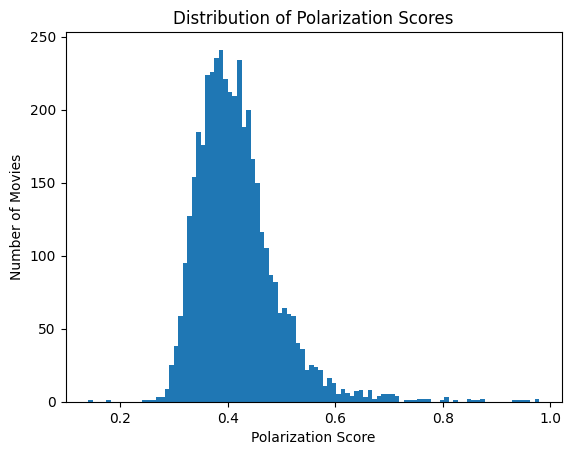

In [24]:
plt.hist(movies['polarization_score'], bins=100)
plt.xlabel('Polarization Score')
plt.ylabel('Number of Movies')
plt.title('Distribution of Polarization Scores')
plt.show()

The distribution of polarization scores is somewhat right-skewed, centered approximately around 0.4.

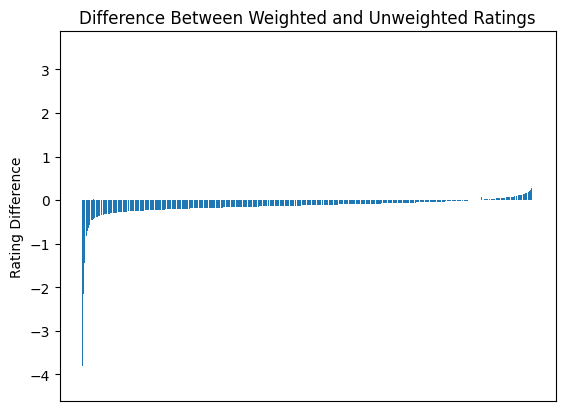

In [25]:
sorted_movies = movies.sort_values('rating_diff', ascending=True)

plt.bar(sorted_movies['title'], sorted_movies['rating_diff'])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Rating Difference')
plt.title('Difference Between Weighted and Unweighted Ratings')
plt.show()

The distribution of rating difference shows that IMDb's weighting algorithm tends to yield lower scores than the unweighted ratings, with some exceptions. Most films' ratings are adjusted by tenths of a point or less, although some, visible on the ends of the distribution, have their ratings drastically altered by the algorithm.

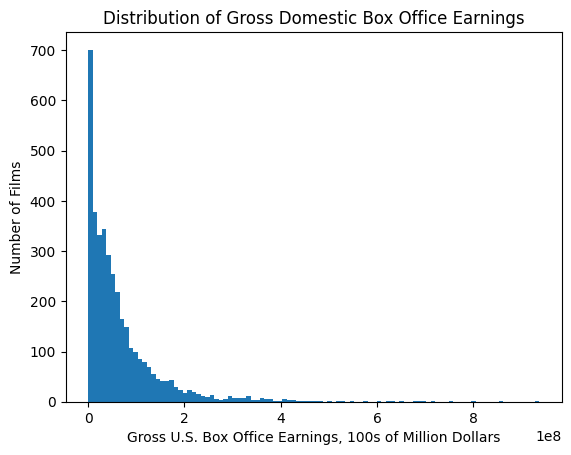

In [26]:
plt.hist(movies_us_release['gross'], bins=100)
plt.xlabel('Gross U.S. Box Office Earnings, 100s of Million Dollars')
plt.ylabel('Number of Films')
plt.title('Distribution of Gross Domestic Box Office Earnings')
plt.show()

This distribution is extremely right-skewed, showing that few films achieve the enormous financial success that studios hope for.

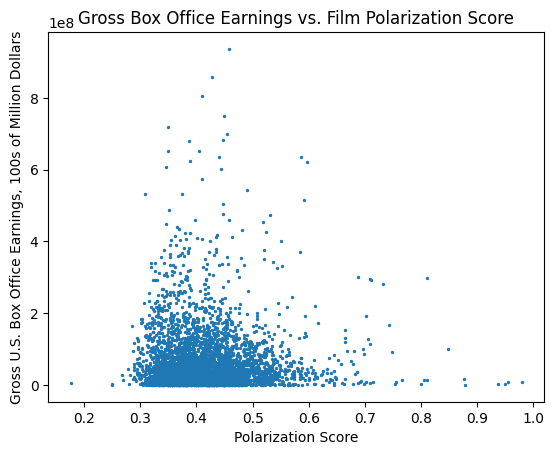

In [27]:
plt.scatter(movies_us_release['polarization_score'], movies_us_release['gross'], s=2)
plt.xlabel('Polarization Score')
plt.ylabel('Gross U.S. Box Office Earnings, 100s of Million Dollars')
plt.title('Gross Box Office Earnings vs. Film Polarization Score')
plt.show()

The plot of gross box office earnings vs polarization score in large part resembles the simple plot of polarization scores. Most high-earning films have polarization scores close to the average (as, for that matter, do most low-earning films). Some notable exceptions, including 2023's Little Mermaid, have achieved strong financial success despite being highly polarizing.

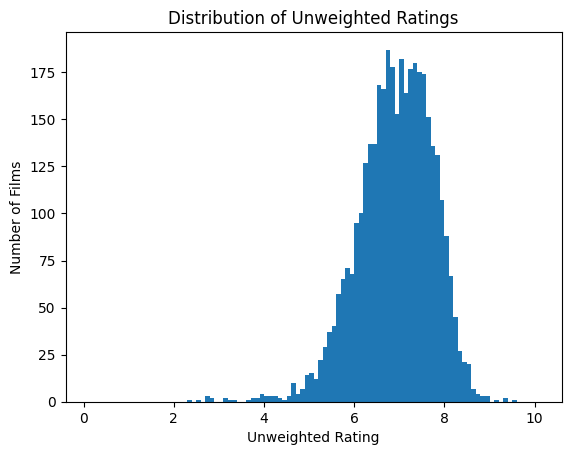

In [28]:
#define bins at each hundredth between 0 and 10
my_bins = [0.1]
for i in range(100):
    my_bins.append(my_bins[i] + 0.1)

plt.hist(movies_us_release['unweighted_rating'], bins=my_bins)
plt.xlabel('Unweighted Rating')
plt.ylabel('Number of Films')
plt.title('Distribution of Unweighted Ratings')
plt.show()

The distribution of unweighted ratings is left-skewed and centered approximately around 7.

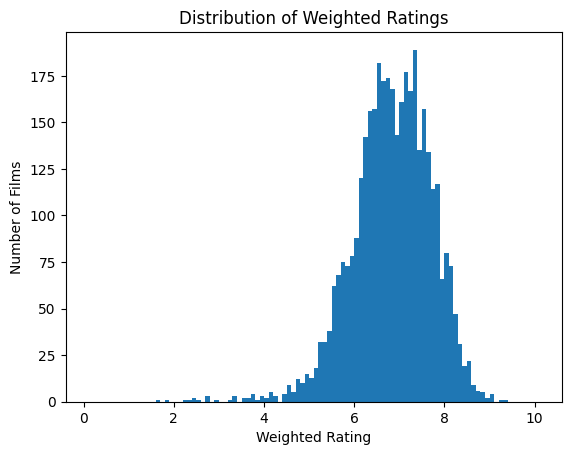

In [29]:
plt.hist(movies_us_release['weighted_rating'], bins=my_bins)
plt.xlabel('Weighted Rating')
plt.ylabel('Number of Films')
plt.title('Distribution of Weighted Ratings')
plt.show()

The distribution of weighted ratings looks very similar—it is also left-skewed and has a center of close to 7. However, on closer examination, it is clear that this distribution has a slightly lower center as a result of the algorithm's tendency to slightly lower ratings.

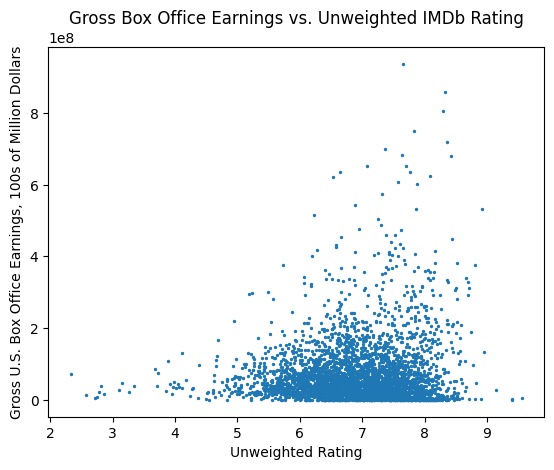

In [30]:
plt.scatter(movies_us_release['unweighted_rating'], movies_us_release['gross'], s=2)
plt.xlabel('Unweighted Rating')
plt.ylabel('Gross U.S. Box Office Earnings, 100s of Million Dollars')
plt.title('Gross Box Office Earnings vs. Unweighted IMDb Rating')
plt.show()

Generally, it seems as though films with higher unweighted ratings on IMDb tend to perform well at the box office. with the absolute most successful rated around the 7 or 8 mark.

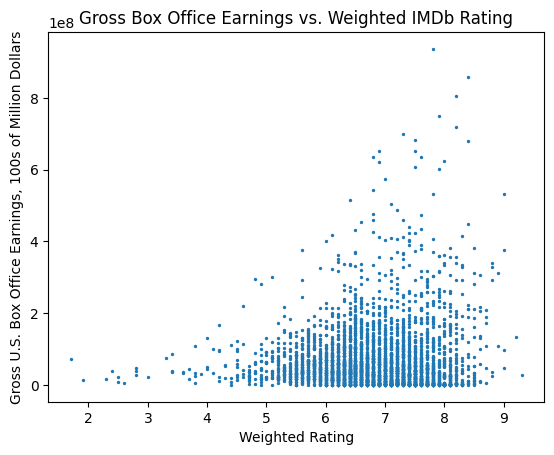

In [31]:
plt.scatter(movies_us_release['weighted_rating'], movies_us_release['gross'], s=2)
plt.xlabel('Weighted Rating')
plt.ylabel('Gross U.S. Box Office Earnings, 100s of Million Dollars')
plt.title('Gross Box Office Earnings vs. Weighted IMDb Rating')
plt.show()

The same plot with rated weightings shows much the same, although the data is organized into neat columns because IMDb only releases weighted ratings in tenths (i.e. 7.1, 7.2, etc) whereas we were able to calculate unweighted ratings precisely using the public score data.

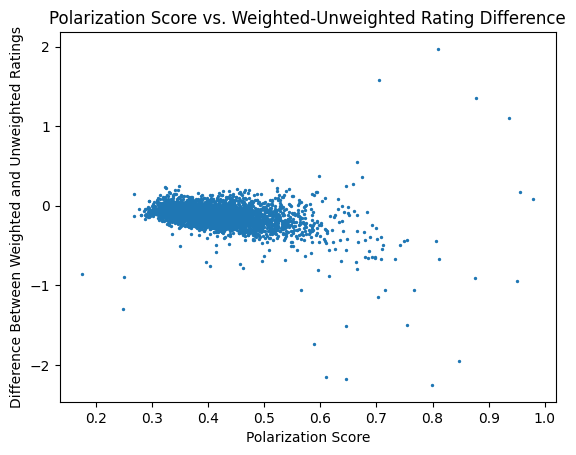

In [32]:
plt.scatter(movies_us_release['polarization_score'], movies_us_release['rating_diff'], s=2)
plt.ylabel('Difference Between Weighted and Unweighted Ratings')
plt.xlabel('Polarization Score')
plt.title('Polarization Score vs. Weighted-Unweighted Rating Difference')
plt.show()

In general, it seems as though films with higher polarization scores are more likely to have their ratings heavily adjusted by the weighting algorithm.

In [33]:
movies_us_release[['polarization_score', 'rating_diff', 'total_votes', 'unweighted_rating', 'weighted_rating', 'gross']].corr()

,polarization_score,rating_diff,total_votes,unweighted_rating,weighted_rating,gross
polarization_score,1.000000,-0.310795,-0.269635,-0.641973,-0.669545,-0.021412
rating_diff,-0.310795,1.000000,0.252300,0.156857,0.329735,0.067810
total_votes,-0.269635,0.252300,1.000000,0.422725,0.449448,0.516013
unweighted_rating,-0.641973,0.156857,0.422725,1.000000,0.984108,0.083052
weighted_rating,-0.669545,0.329735,0.449448,0.984108,1.000000,0.091582
gross,-0.021412,0.067810,0.516013,0.083052,0.091582,1.000000


Here, a few notable correlations are strong negative correlations between `polarization_score` and both `unweighted_rating` and `weighted_rating`. `unweighted_rating` and `weighted_rating` are, as expected, very strongly postively correlated with each other. `total_votes` is moderately positively correlated with `gross`.

In [34]:
X = movies_us_release[['polarization_score', 'rating_diff', 'total_votes', 'unweighted_rating', 'weighted_rating']]
y = movies_us_release['gross']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     391.8
Date:                Thu, 10 Apr 2025   Prob (F-statistic):          7.38e-283
Time:                        03:05:03   Log-Likelihood:                -74164.
No. Observations:                3800   AIC:                         1.483e+05
Df Residuals:                    3795   BIC:                         1.484e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.037e+08   1.99